<a href="https://colab.research.google.com/github/diptivs/machine_learning/blob/master/CMPE_257_Clustering_Dipti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataSet contains total of 25 columns generated by merging  emails dataset and stocks data for enron. After running Vader on email Dataset, the coloumns indicating emotions were generated which are positive, negative, neutral, compound and emotions. The coloumns used for clustering are precentage change of stock price and compound value of emotions.

Currently id is used as index but have also tried with Date as index. Clustering looks similar.

The stock change data is spread across the emotions. So with current clustering results we really could not visualize the relationship between stock change and emotions. We will be labelling this data as per clustering results and process further.

In [0]:
#Read Data from DataSet

import pandas as pd
from sklearn.cluster import KMeans
from math import sqrt
import numpy as np

# Setup google auth
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# load the file
file_id = '1w4uPyK9hH8E-k_NCDd1xpaFK1SXWCEZ0'
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('emails_parsed_sentiment_n_stock.csv')  
data_in = pd.read_csv('emails_parsed_sentiment_n_stock.csv', index_col="id")

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas_datareader as dr
from matplotlib import pyplot as plt

from datetime import datetime


data = np.asarray([np.asarray(data_in['ChangePercent']), np.asarray(data_in['compound'])]).T
#data = np.asarray([np.asarray(data_in['ChangePercent']),np.asarray(data_in['negative']),np.asarray(data_in['neutral']),np.asarray(data_in['positive']),np.asarray(data_in['compound'])]).T


X = data

print(X)

[[ 0.945  0.   ]
 [ 1.937  0.114]
 [-0.556  0.539]
 ...
 [ 5.407  0.066]
 [-6.448  0.166]
 [ 6.024  0.091]]


**Plot Elbow**

Plotted elbow which shows 3 or 4 is good number as K value.

Text(0.5, 1.0, 'Elbow curve')

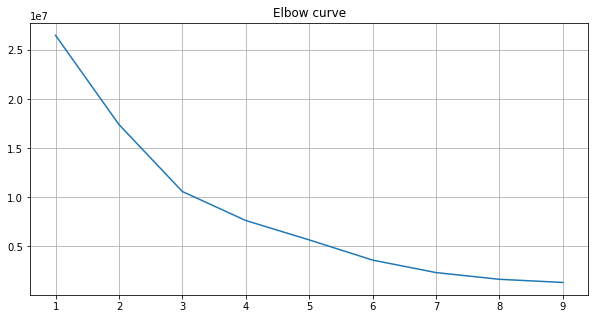

In [0]:
#Plt Elbow

distorsions = []
for k in range(1, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

**Mini-batch clustering algorithm from Tensor Flow**

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpws9wl4ko', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa7e51d8208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create 

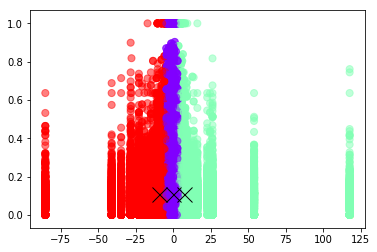

In [0]:
#mini-batch using Tensor Flow
import tensorflow as tf

k = 3
variables = 2
points = X
input_fn=lambda: tf.train.limit_epochs(tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)
kmeans=tf.contrib.factorization.KMeansClustering(num_clusters=k, use_mini_batch=True)
previous_centers = None
for _ in range(10):
    kmeans.train(input_fn)
    centers = kmeans.cluster_centers()
    previous_centers = centers

cluster_indices = list(kmeans.predict_cluster_index(input_fn))

plt.scatter(points[:, 0], points[:, 1], c=cluster_indices, s=50, alpha=0.5, cmap ="rainbow")
plt.plot(centers[:, 0], centers[:, 1], 'kx', markersize=15)
plt.show()

**Afiinity Propogation Algorithm.**

Our dataset contains 517401 rows and Affinity propogation algorithm is crashing with such huge data. So plotted with reducing the data to 10000 Data points.

We will be reducing the data to this limit by having only one row for each day and by averaging the compound value for all emotions for that day.

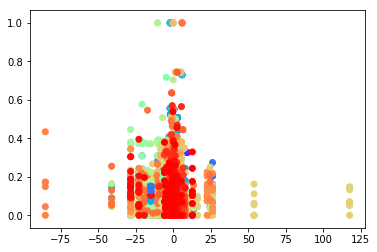

In [0]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

plt.scatter(X[:,0],X[:,1], c = af.labels_, cmap ="rainbow")
plt.show()

**Ward Clustering Algorithm**

Sklearn had a seperate library for Ward algorithm which is deprecated with latest Sklearn. 

Now sklearn has ward_tree which is used for hiriarchical clustering giving the output as node and leaves.

Here we have plotted Ward clustering using AgglomerativeClustering algorithm with Ward Linkage

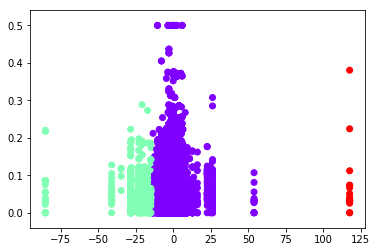

In [0]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll

# #############################################################################

# Make it thinner
X[:, 1] *= .5

# #############################################################################
# Compute clustering
ward = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(X)
label = ward.labels_

plt.scatter(X[:,0],X[:,1], c = ward.labels_, cmap ="rainbow")
plt.show()

**DBSCAN Algorithm using Tensor Flow**

Reference: https://github.com/pmarcol/dbscan_tf

In [0]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


def dbtf_run(vals, epsilon=4, min_points=4):
  
    def merge_core_points_into_clusters(elems):
        row = elems
        mat = core_points_connection_matrix
        nonempty_intersection_inds = tf.where(tf.reduce_any(tf.logical_and(row, mat), axis=1))
        cumul = tf.logical_or(row, mat)
        subcumul = tf.gather_nd(cumul, nonempty_intersection_inds)
        return tf.reduce_any(subcumul, axis=0)

    def label_clusters(elems):
        return tf.reduce_min(tf.where(elems))

    def get_subsets_for_labels(elems):
        val = elems[0]
        labels = elems[1]
        conn = relation_matrix
        
        inds = tf.where(tf.equal(labels, val))
        masks = tf.gather_nd(conn, inds)
        return tf.reduce_any(masks, axis=0)

    def scatter_labels(elems):
        label = tf.expand_dims(elems[0], 0)
        mask = elems[1]
        return label*tf.cast(mask, dtype=tf.int64)

    #data_np = np.array(vals).reshape((-1, 1))
    data_np = np.array(vals)

    eps = epsilon
    min_pts = min_points

    in_set = tf.placeholder(tf.float64)

    # distance matrix
    r = tf.reduce_sum(in_set*in_set, 1)
    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    dist_mat = tf.sqrt(r - 2*tf.matmul(in_set, tf.transpose(in_set)) + tf.transpose(r))

    # for every point show, which points are within eps distance of that point (including that point)
    relation_matrix = dist_mat <= eps

    # number of points within eps-ball for each point
    num_neighbors = tf.reduce_sum(tf.cast(relation_matrix, tf.int64), axis=1)

    # for each point show, whether this point is core point
    core_points_mask = num_neighbors >= min_pts

    # indices of core points
    core_points_indices = tf.where(core_points_mask)

    core_points_connection_matrix = tf.cast(core_points_mask, dtype=tf.int64) * tf.cast(relation_matrix, dtype=tf.int64)
    core_points_connection_matrix = tf.cast(core_points_connection_matrix, dtype=tf.bool)
    core_points_connection_matrix = tf.logical_and(core_points_connection_matrix, core_points_mask)

    merged = tf.map_fn(
        merge_core_points_into_clusters,
        core_points_connection_matrix,
        dtype=tf.bool
    )

    nonempty_clusters_records = tf.gather_nd(merged, core_points_indices)

    marked_core_points = tf.map_fn(label_clusters, nonempty_clusters_records, dtype=tf.int64)

    _, labels_core_points = tf.unique(marked_core_points, out_idx=tf.int64)

    labels_core_points = labels_core_points+1

    unique_labels, _ = tf.unique(labels_core_points)

    labels_all = tf.scatter_nd(
        tf.cast(core_points_indices, tf.int64),
        labels_core_points,
        shape=tf.cast(tf.shape(core_points_mask), tf.int64)
    )

    # for each label return mask, which points should have this label
    ul_shape = tf.shape(unique_labels)
    labels_tiled = tf.maximum(tf.zeros([ul_shape[0], 1], dtype=tf.int64), labels_all)

    labels_subsets = tf.map_fn(
        get_subsets_for_labels,
        (unique_labels, labels_tiled),
        dtype=tf.bool
    )

    final_labels = tf.map_fn(
        scatter_labels,
        elems=(tf.expand_dims(unique_labels, 1), labels_subsets),
        dtype=tf.int64
    )

    final_labels = tf.reduce_max(final_labels, axis=0)

    with tf.Session() as sess:

        results = (sess.run(final_labels, feed_dict={in_set:data_np})).reshape((1, -1))

    results = results.reshape((-1, 1))

    return results

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


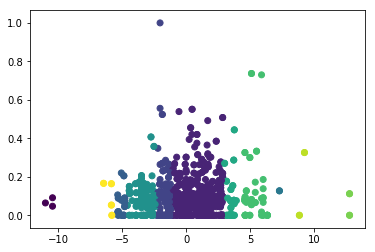

In [0]:
blobs_results = dbtf_run(X, epsilon=1, min_points=4)

plt.scatter(X[:,0], X[:,1], c=blobs_results.flatten())
plt.show()